## Clasificación y Predicción

Vamos a aprender como combinar varias técnicas de ingeniería de variables que cubrimos a lo largo de este curso y cómo aplicarlas en un problema de clasificación. Esto te dará una idea de un flujo de trabajo de principio a fin para construir un modelo de aprendizaje de máquina en problemas de clasificación y predicción.

Verás como:
- construir un árbol de potenciación del gradiente
- usar feature-engine para los diferentes pasos de ingeniería de variables
- crear un flujo completo para la ingeniería y la clasificación de las observaciones usando el 'Pipeline' de Scikit-learn

===================================================================================================

## En este demo:


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# para el modelo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# para la ingeniería de las variables
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [ ]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 4.4 MB/s 
     |████████████████████████████████| 9.8 MB 45.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# cargar los datos

cols = [
    'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
    'embarked', 'survived'
]
#data=sns.load_dataset('titanic')

url='https://docs.google.com/spreadsheets/d/e/2PACX-1vQvGGrtH7Xi40KA3KlQtiOENfyoMpjp4i-0zKEfH95c5FJCRIJWEdvtHZc2ZHK9Jg/pub?gid=1268983807&single=true&output=csv'
data = pd.read_csv(url, usecols=cols)

data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B5,S
1,1,1,male,0.9167,1,2,151.5500,C22 C26,S
2,1,0,female,2.0000,1,2,151.5500,C22 C26,S
3,1,0,male,30.0000,1,2,151.5500,C22 C26,S
4,1,0,female,25.0000,1,2,151.5500,C22 C26,S


### Tipos de variables (sección 2)

Veamos que tipos de variables tenemos en los datos

In [ ]:
# inspeccionemos los tipos de variables usando pandas

data.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
dtype: object

Hay variables categóricas y numéricas

In [ ]:
# inspeccionemos los valores de las variables

for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

pclass [1 2 3] 

survived [1 0] 

sex ['female' 'male'] 

age [29.      0.9167  2.     30.     25.     48.     63.     39.     53.
 71.     47.     18.     24.     26.     80.         nan 50.     32.
 36.     37.    ] 

sibsp [0 1 2 3 4 5 8] 

parch [0 2 1 4 3 5 6 9] 

fare [211.3375 151.55    26.55    77.9583   0.      51.4792  49.5042 227.525
  69.3     78.85    30.      25.925  247.5208  76.2917  75.2417  52.5542
 221.7792  26.      91.0792 135.6333] 

cabin ['B5' 'C22 C26' 'E12' 'D7' 'A36' 'C101' nan 'C62 C64' 'B35' 'A23'
 'B58 B60' 'D15' 'C6' 'D35' 'C148' 'C97' 'B49' 'C99' 'C52' 'T'] 

embarked ['S' 'C' nan 'Q'] 



Hay una combinación de variables discretas y continuas. Tambien vemos variables mixtas

In [ ]:
# crea una lista con el tipo de variables

# numéricas: discretas vs. continuas
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='survived' and data[var].nunique()<10]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='survived' and var not in discrete]

# mixtas
mixed = ['cabin']

# categóricas
categorical = [var for var in data.columns if data[var].dtype=='O' and var not in mixed]

print('Hay {} variables discretas'.format(len(discrete)))
print('Hay {} variables continuas'.format(len(continuous)))
print('Hay {} variables categóricas'.format(len(categorical)))
print('Hay {} variables mixtas'.format(len(mixed)))

Hay 3 variables discretas
Hay 2 variables continuas
Hay 2 variables categóricas
Hay 1 variables mixtas


In [ ]:
discrete

['pclass', 'sibsp', 'parch']

In [ ]:
continuous

['age', 'fare']

In [ ]:
categorical

['sex', 'embarked']

In [ ]:
mixed

['cabin']

### Características de las Variables  (sección 3)

In [ ]:
# datos ausentes

data.isnull().mean()

pclass      0.000000
survived    0.000000
sex         0.000000
age         0.200917
sibsp       0.000000
parch       0.000000
fare        0.000764
cabin       0.774637
embarked    0.001528
dtype: float64

Hay datos ausentes en nuestras variables

In [ ]:
# cardinalidad (número de diferentes categorías)

data[categorical+mixed].nunique()

sex           2
embarked      3
cabin       186
dtype: int64

Algunas variables tienen alta cardinalidad.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


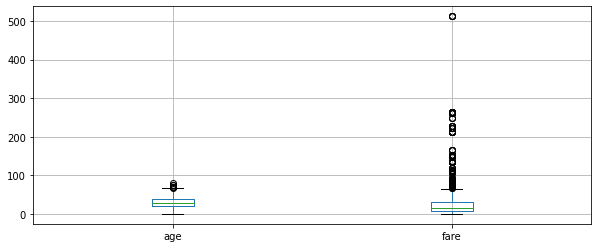

In [ ]:
# outliers o valores extremos

data[continuous].boxplot(figsize=(10,4))

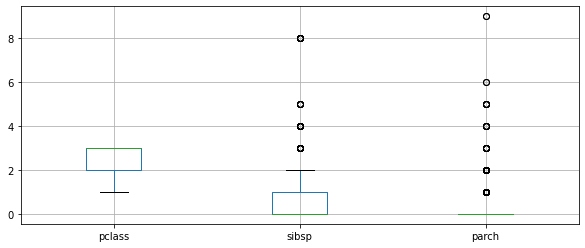

In [ ]:
# outliers en las variables discretas
data[discrete].boxplot(figsize=(10,4))

Algunas variables tienen outliers o valores inusuales

In [ ]:
# valores más grandes que 3 son poco comunes
# para la variable 'parch'

data['cabin'].value_counts()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
F4                 4
F33                4
                  ..
C132               1
E60                1
B52 B54 B56        1
C49                1
F38                1
Name: cabin, Length: 186, dtype: int64

In [ ]:
# escala de las variables

data.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [ ]:
data.describe(include='O')

,sex,cabin,embarked
count,1309,295,1307
unique,2,186,3
top,male,C23 C25 C27,S
freq,843,6,914


Las variables tienen diferentes rango o escalas de valores. Sin embargo, esto no es relevante para árboles de potenciación de gradiente.

### Ingeniería de variables mixtas (sección 11)

Extraer las partes numéricas y categóricas de la variable

In [ ]:
# Cabin
data['cabin_num'] = data['cabin'].str.extract('(\d+)') # captura la parte numéricas
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['cabin'].str[0] # captura la primera letra

# mostrar dataframe
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,cabin_num,cabin_cat
0,1,1,female,29.0000,0,0,211.3375,B5,S,5.0,B
1,1,1,male,0.9167,1,2,151.5500,C22 C26,S,22.0,C
2,1,0,female,2.0000,1,2,151.5500,C22 C26,S,22.0,C
3,1,0,male,30.0000,1,2,151.5500,C22 C26,S,22.0,C
4,1,0,female,25.0000,1,2,151.5500,C22 C26,S,22.0,C


Ahora que extrajimos la parte numérica y categórica, podemos eliminar la variable mixta Cabin.

In [ ]:
# eliminar variable Cabin.

data.drop(['cabin'], axis=1, inplace=True)

In [ ]:
# separar los sets de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predicciones
    data['survived'],  # target
    test_size=0.1,  # porcentaje de observaciones set prueba
    random_state=0)  # semilla para garantizar reproducibilidad

X_train.shape, X_test.shape

((1178, 9), (131, 9))

### Imputación datos ausentes (Sección 4)

In [ ]:
# variables numéricas

X_train.select_dtypes(exclude='O').isnull().mean()

pclass       0.000000
age          0.198642
sibsp        0.000000
parch        0.000000
fare         0.000849
cabin_num    0.776740
dtype: float64

In [ ]:
# variables categóricas

X_train.select_dtypes(include='O').isnull().mean()

sex          0.000000
embarked     0.001698
cabin_cat    0.771647
dtype: float64

Métodos de imputación que vamos a usar:

- numéricas: imputación por valor arbitrario
- categóricas: añadir etiqueta 'missing'

Ya que vamos a construir un árbol de potenciación de gradiente, no estamos preocupados por alterar la linealidad o la distribución de las variables.

### Codificación variables categóricas y etiquetas poco comunes  (Sección 6)

In [ ]:
# revisa la cardinalidad nuevamente

X_train[['cabin_cat', 'sex', 'embarked']].nunique()

cabin_cat    8
sex          2
embarked     3
dtype: int64

Ahora que extrajimos la parte numérica y categórica de la variable 'cabin', la cardinalidad no es tan alta.


In [ ]:
# revisa la variable 'frequency'

var = 'cabin_cat'
(X_train[var].value_counts() / len(X_train)).sort_values()

T    0.000849
G    0.003396
A    0.016978
F    0.016978
E    0.033107
D    0.033956
B    0.049236
C    0.073854
Name: cabin_cat, dtype: float64

Las categorías T y G están presentes en solo unas observaciones, por lo tanto las consideramos como categorías poco comunes y las reemplazaremos con la categoría 'rare'.

### Discretización o transformación de Variables  (Sección 7 y 8)

Inspeccionemos las distribuciones de las variables

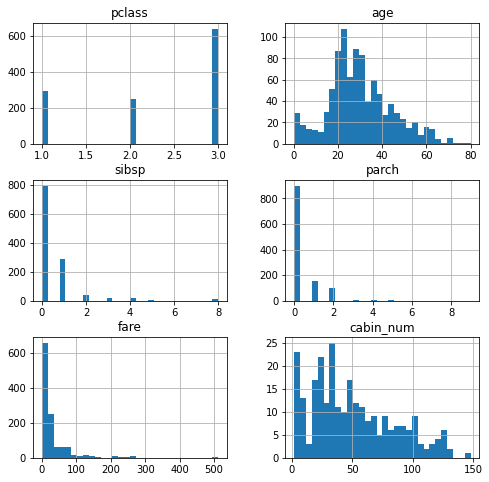

In [ ]:
# variables numéricas

X_train.select_dtypes(exclude='O').hist(bins=30, figsize=(8,8))
plt.show()

Para los árboles de decisión, la distribución de las variables no es importante, por lo tanto, en principio no necestiamos cambiarla. Los árboles de decisión también son robustos a los outliers o valores extremos

### Poniendo todo junto

In [ ]:
# Creemos pipelne
titanic_pipe = Pipeline([

    # imputación de datos ausentes - sección 4
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['age', 'fare', 'cabin_num'])),
    ('imputer_cat',
     mdi.CategoricalImputer(variables=['embarked', 'cabin_cat'])),

    # codificación de variables categóricas - sección 6
    ('encoder_rare_label',
     ce.RareLabelEncoder(tol=0.01,
                         n_categories=6,
                         variables=['cabin_cat'])),

    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                       variables=['cabin_cat', 'sex', 'embarked'])),

    # máquina de potenciación de gradiente
    ('gbm', GradientBoostingClassifier(random_state=0))
])

In [ ]:
# ajustemos el pipeline o flujo de trabajo
titanic_pipe.fit(X_train, y_train)

# generemos las predicciones
X_train_preds = titanic_pipe.predict_proba(X_train)[:,1]
X_test_preds = titanic_pipe.predict_proba(X_test)[:,1]

In [ ]:
# veamos las predicciones
X_train_preds

array([0.28241095, 0.09396436, 0.56340128, ..., 0.70308678, 0.91646677,
       0.5795444 ])

In [ ]:
print('Set de entrenamiento')
print('GBM roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Set de prueba')
print('GBM roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Set de entrenamiento
GBM roc-auc: 0.9261637899509982
Set de prueba
GBM roc-auc: 0.8426204819277108


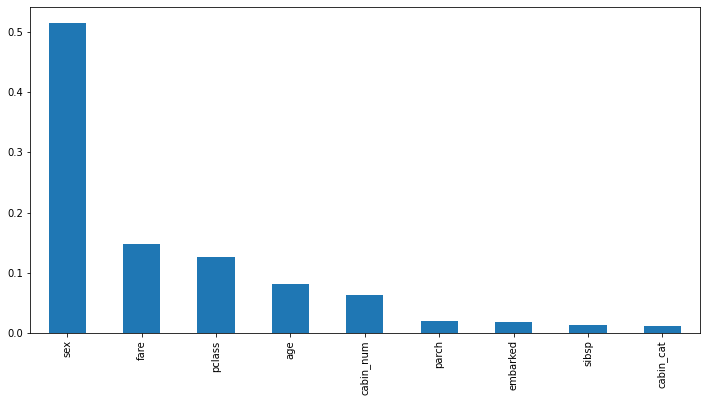

In [ ]:
# exploremos la importancia de las variables

importance = pd.Series(titanic_pipe.named_steps['gbm'].feature_importances_)
importance.index = data.drop('survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))